In [1]:
! pip install -r requirements.txt --q

In [2]:
! pip install torch-geometric \
  torch-sparse \
  torch-scatter \
  torch-cluster \
  torch-cluster \
  pyg-lib \
  -f https://data.pyg.org/whl/torch-2.4.0+cu124.html --q

## Init

In [3]:
# Standard library imports
import os
import sys
import gc
import json
import random
import pyperclip
from datetime import datetime, timedelta

# Data manipulation and analysis
import numpy as np
import pandas as pd
from tqdm import tqdm
from math import radians, cos, sin, asin, sqrt
pd.set_option('display.max_columns', None)

# Visualization
import matplotlib.pyplot as plt
import folium

# Geospatial libraries
import osmnx as ox
import geopandas as gpd
from geopy.distance import geodesic
from haversine import haversine, Unit

# Deep learning and network libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import torch.optim as optim

from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, SAGEConv, knn_graph
from torch.utils.data import random_split 
from torch_geometric.utils import from_networkx, to_networkx, k_hop_subgraph 
from torch_geometric.data import Data
from torch_geometric.loader import NeighborLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Print current time for tracking execution
start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Notebook execution started at: {start_time}")

d:\MinhVu\Study\GNN\Project\EV_Route_Optimization\.venv\lib\site-packages\torch_geometric\typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: Could not find module 'D:\MinhVu\Study\GNN\Project\EV_Route_Optimization\.venv\Lib\site-packages\libpyg.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
d:\MinhVu\Study\GNN\Project\EV_Route_Optimization\.venv\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
d:\MinhVu\Study\GNN\Project\EV_Route_Optimization\.venv\lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The sp

Notebook execution started at: 2025-04-13 19:55:53


In [4]:
def daynum_to_datetime(daynum):
    """
    Convert a DayNum float to a datetime object.
    
    DayNum 1 corresponds to Nov 1st, 2017, 00:00:00.
    """
    # Reference date: DayNum 1 = Nov 1st, 2017, 00:00:00
    reference_date = datetime(2017, 11, 1, 0, 0, 0)

    # Calculate the timedelta from the reference date
    delta = timedelta(days=daynum - 1)
    
    # Add the timedelta to the reference date
    result_datetime = reference_date + delta
    
    return result_datetime

## 1. Preparation

In [5]:
# Create dictionary for mapping of VehId to Vehicle_Type
df_IceHev = pd.read_excel ('VED-master\Data\VED_Static_Data_ICE&HEV.xlsx')
df_IceHev.rename(columns={'Vehicle Type': 'Vehicle_Type'}, inplace=True)
df_PhevEv = pd.read_excel ('VED-master\Data\VED_Static_Data_PHEV&EV.xlsx')
df_PhevEv.rename(columns={'EngineType': 'Vehicle_Type'}, inplace=True)
df_VehId = pd.concat([df_IceHev, df_PhevEv], ignore_index = True)
df_VehId.sort_values(by='VehId', inplace=True)
# Function to convert "NO DATA" strings to NaN values
def convert_no_data_to_nan(df, columns=None):
    if columns is None:
        columns = df.columns
    for col in columns:
        if df[col].dtype == 'object':  # Only apply to string columns
            df[col] = df[col].replace('NO DATA', np.nan)
    return df

# Apply the function to convert "NO DATA" to NaN values
df_VehId = convert_no_data_to_nan(df_VehId)
df_VehId.drop(columns=['Transmission', 'Drive Wheels'], inplace=True)
df_VehId['Generalized_Weight'] = df_VehId['Generalized_Weight'].astype('Int64')

# Drop rows with any NaN values
df_VehId.dropna(how='any', axis=0, inplace=True)
df_VehId

C:\Users\MinhVu\AppData\Local\Temp\ipykernel_29460\3353746229.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace('NO DATA', np.nan)


,VehId,Vehicle_Type,Vehicle Class,Engine Configuration & Displacement,Generalized_Weight
0,2,ICE,Car,4-FI 2.0L T/C,3500
1,5,HEV,Car,4-GAS/ELECTRIC 2.0L,3500
2,7,ICE,SUV,6-FI 3.6L,4500
3,8,ICE,Car,4-FI 1.5L,2500
357,9,PHEV,Car,4-GAS/ELECTRIC 1.4L,4000
358,10,EV,Car,ELECTRIC,3500
359,11,PHEV,Car,4-GAS/ELECTRIC 2.0L,4000
4,12,ICE,Car,4-FI 1.8L,2500
360,371,PHEV,Car,4-GAS/ELECTRIC 2.0L,4000
361,379,PHEV,Car,4-GAS/ELECTRIC 1.4L,4000


In [6]:
pd.read_excel ('VED-master\Data\VED_Static_Data_ICE&HEV.xlsx').head()

,VehId,Vehicle Type,Vehicle Class,Engine Configuration & Displacement,Transmission,Drive Wheels,Generalized_Weight
0,2,ICE,Car,4-FI 2.0L T/C,NO DATA,NO DATA,3500
1,5,HEV,Car,4-GAS/ELECTRIC 2.0L,NO DATA,NO DATA,3500
2,7,ICE,SUV,6-FI 3.6L,AUTOMATIC,NO DATA,4500
3,8,ICE,Car,4-FI 1.5L,5-SP MANUAL,NO DATA,2500
4,12,ICE,Car,4-FI 1.8L,NO DATA,NO DATA,2500


In [7]:
pd.read_excel('VED-master\Data\VED_Static_Data_PHEV&EV.xlsx').head()

,VehId,EngineType,Vehicle Class,Engine Configuration & Displacement,Transmission,Drive Wheels,Generalized_Weight
0,9,PHEV,Car,4-GAS/ELECTRIC 1.4L,NO DATA,FWD,4000
1,10,EV,Car,ELECTRIC,NO DATA,FWD,3500
2,11,PHEV,Car,4-GAS/ELECTRIC 2.0L,CVT,FWD,4000
3,371,PHEV,Car,4-GAS/ELECTRIC 2.0L,CVT,FWD,4000
4,379,PHEV,Car,4-GAS/ELECTRIC 1.4L,NO DATA,FWD,4000


In [8]:
pd.read_csv('VED-master\\Data\\VED_171129_week.csv').head(10)

,DayNum,VehId,Trip,Timestamp(ms),Latitude[deg],Longitude[deg],Vehicle Speed[km/h],MAF[g/sec],Engine RPM[RPM],Absolute Load[%],OAT[DegC],Fuel Rate[L/hr],Air Conditioning Power[kW],Air Conditioning Power[Watts],Heater Power[Watts],HV Battery Current[A],HV Battery SOC[%],HV Battery Voltage[V],Short Term Fuel Trim Bank 1[%],Short Term Fuel Trim Bank 2[%],Long Term Fuel Trim Bank 1[%],Long Term Fuel Trim Bank 2[%]
0,29.572386,8,805,0,42.266449,-83.706693,50.0,3.64,1610.0,16.862745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.8125,NaN,7.8125,NaN
1,29.572386,8,805,1300,42.266449,-83.706693,46.0,3.21,1411.0,16.862745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.8125,NaN,7.8125,NaN
2,29.572386,8,805,2400,42.266449,-83.706693,45.0,3.21,1411.0,16.862745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.8125,NaN,7.8125,NaN
3,29.572386,8,805,3600,42.266449,-83.706693,44.0,2.90,1346.0,14.509804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,7.8125,NaN
4,29.572386,8,805,5700,42.266449,-83.706693,44.0,2.93,1350.0,14.509804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,7.8125,NaN
5,29.572386,8,805,7300,42.266449,-83.706693,45.0,2.93,1350.0,14.509804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,7.8125,NaN
6,29.572386,8,805,7700,42.266449,-83.706693,45.0,3.02,1387.0,14.509804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,7.8125,NaN
7,29.572386,8,805,8100,42.267909,-83.706651,45.0,3.02,1387.0,14.509804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,7.8125,NaN
8,29.572386,8,805,9400,42.267909,-83.706651,46.0,3.02,1387.0,14.509804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,7.8125,NaN
9,29.572386,8,805,9800,42.267909,-83.706651,46.0,3.08,1414.0,14.509804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,7.8125,NaN


In [9]:
pd.read_csv('datarepo-eved-dataset-549403600cf5/data/eVED/eVED_171101_week.csv').head(10)

C:\Users\MinhVu\AppData\Local\Temp\ipykernel_29460\3207840020.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('datarepo-eved-dataset-549403600cf5/data/eVED/eVED_171101_week.csv').head(10)


,DayNum,VehId,Trip,Timestamp(ms),Latitude[deg],Longitude[deg],Vehicle Speed[km/h],MAF[g/sec],Engine RPM[RPM],Absolute Load[%],OAT[DegC],Fuel Rate[L/hr],Air Conditioning Power[kW],Air Conditioning Power[Watts],Heater Power[Watts],HV Battery Current[A],HV Battery SOC[%],HV Battery Voltage[V],Short Term Fuel Trim Bank 1[%],Short Term Fuel Trim Bank 2[%],Long Term Fuel Trim Bank 1[%],Long Term Fuel Trim Bank 2[%],Elevation Raw[m],Elevation Smoothed[m],Gradient,Energy_Consumption,Matchted Latitude[deg],Matched Longitude[deg],Match Type,Class of Speed Limit,Speed Limit[km/h],Speed Limit with Direction[km/h],Intersection,Bus Stops,Focus Points
0,1.586651,8.0,706.0,0.0,42.277558,-83.698750,40.0,22.129999,2285.0,49.019608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230.563034,230.563034,0.000000,NaN,42.277558,-83.698767,0,0.0,56,56.0,NaN,NaN,NaN
1,1.586651,8.0,706.0,200.0,42.277558,-83.698750,40.0,22.129999,2285.0,67.450981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230.563034,230.563034,0.000000,NaN,42.277558,-83.698767,1,0.0,56,56.0,NaN,NaN,NaN
2,1.586651,8.0,706.0,1100.0,42.277558,-83.698750,45.0,22.129999,2285.0,67.450981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230.563034,230.563034,0.000000,NaN,42.277558,-83.698767,1,0.0,56,56.0,NaN,NaN,NaN
3,1.586651,8.0,706.0,2100.0,42.277558,-83.698750,47.0,6.150000,2744.0,67.450981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230.563034,230.595203,0.000000,NaN,42.277558,-83.698767,1,0.0,56,56.0,NaN,NaN,NaN
4,1.586651,8.0,706.0,4200.0,42.277558,-83.698750,48.0,21.440001,1982.0,67.450981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230.563034,230.627371,0.000415,NaN,42.277558,-83.698767,1,0.0,56,56.0,NaN,NaN,NaN
5,1.586651,8.0,706.0,5200.0,42.278255,-83.698803,52.0,21.440001,1982.0,78.039215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230.723877,230.659540,0.000000,NaN,42.278255,-83.698812,0,0.0,64,64.0,NaN,NaN,NaN
6,1.586651,8.0,706.0,6300.0,42.278255,-83.698803,55.0,26.510000,2230.0,78.039215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230.723877,230.691708,0.000000,NaN,42.278255,-83.698812,1,0.0,64,64.0,NaN,NaN,NaN
7,1.586651,8.0,706.0,7400.0,42.278255,-83.698803,59.0,26.510000,2230.0,78.039215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230.723877,230.824719,0.000000,NaN,42.278255,-83.698812,1,0.0,64,64.0,NaN,NaN,NaN
8,1.586651,8.0,706.0,8400.0,42.278255,-83.698803,59.0,11.660000,2297.0,78.039215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230.723877,230.925562,0.001193,NaN,42.278255,-83.698812,1,0.0,64,64.0,NaN,NaN,NaN
9,1.586651,8.0,706.0,10600.0,42.279013,-83.698901,60.0,13.390000,1841.0,49.019608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,231.228088,231.026404,0.000000,NaN,42.279011,-83.698912,0,0.0,64,64.0,NaN,NaN,NaN


In [10]:
%%time
df_list = []
input_dir = "datarepo-eved-dataset-549403600cf5/data/eVED/"
file_list = os.listdir(input_dir)
file_list = [file for file in file_list if file.endswith("_week.csv")]

for i in range(len(file_list)):
    df = pd.read_csv(input_dir + file_list[i], low_memory=False)
    print(f"Reading file ({i+1}/{len(file_list)}): {file_list[i]} (len = {len(df)})")
    df = df[df['Energy_Consumption'].notnull()]
    df['Energy_Consumption'] = abs(df['Energy_Consumption'])
    df_list.append(df)

raw_df = pd.concat(df_list)

print("=============================================")
print(f"Total records: {len(raw_df)}")

Reading file (1/54): eVED_171101_week.csv (len = 489414)
Reading file (2/54): eVED_171108_week.csv (len = 535198)
Reading file (3/54): eVED_171115_week.csv (len = 602092)
Reading file (4/54): eVED_171122_week.csv (len = 474329)
Reading file (5/54): eVED_171129_week.csv (len = 531856)
Reading file (6/54): eVED_171206_week.csv (len = 589154)
Reading file (7/54): eVED_171213_week.csv (len = 670084)
Reading file (8/54): eVED_171220_week.csv (len = 539468)
Reading file (9/54): eVED_171227_week.csv (len = 311927)
Reading file (10/54): eVED_180103_week.csv (len = 393498)
Reading file (11/54): eVED_180110_week.csv (len = 550780)
Reading file (12/54): eVED_180117_week.csv (len = 526771)
Reading file (13/54): eVED_180124_week.csv (len = 456757)
Reading file (14/54): eVED_180131_week.csv (len = 479522)
Reading file (15/54): eVED_180207_week.csv (len = 419846)
Reading file (16/54): eVED_180214_week.csv (len = 389642)
Reading file (17/54): eVED_180221_week.csv (len = 285924)
Reading file (18/54): e

In [11]:
raw_df.head(10)

,DayNum,VehId,Trip,Timestamp(ms),Latitude[deg],Longitude[deg],Vehicle Speed[km/h],MAF[g/sec],Engine RPM[RPM],Absolute Load[%],OAT[DegC],Fuel Rate[L/hr],Air Conditioning Power[kW],Air Conditioning Power[Watts],Heater Power[Watts],HV Battery Current[A],HV Battery SOC[%],HV Battery Voltage[V],Short Term Fuel Trim Bank 1[%],Short Term Fuel Trim Bank 2[%],Long Term Fuel Trim Bank 1[%],Long Term Fuel Trim Bank 2[%],Elevation Raw[m],Elevation Smoothed[m],Gradient,Energy_Consumption,Matchted Latitude[deg],Matched Longitude[deg],Match Type,Class of Speed Limit,Speed Limit[km/h],Speed Limit with Direction[km/h],Intersection,Bus Stops,Focus Points,Focus Points;
416,1.719774,10.0,1558.0,0.0,42.277066,-83.763404,53.590000,NaN,NaN,NaN,5.0,NaN,NaN,0.0,2250.0,-21.5,96.341469,386.0,NaN,NaN,NaN,NaN,265.259003,265.259003,0.000000,0.002305,42.276966,-83.763366,0,0.0,48,48.0,NaN,NaN,NaN,NaN
417,1.719774,10.0,1558.0,200.0,42.277066,-83.763404,51.980000,NaN,NaN,NaN,5.0,NaN,NaN,0.0,2250.0,-21.5,96.341469,386.0,NaN,NaN,NaN,NaN,265.259003,265.259003,0.000000,0.002305,42.276966,-83.763366,1,0.0,48,48.0,NaN,NaN,NaN,NaN
418,1.719774,10.0,1558.0,1200.0,42.277066,-83.763404,50.369999,NaN,NaN,NaN,5.0,NaN,NaN,0.0,2250.0,-21.5,96.341469,386.0,NaN,NaN,NaN,NaN,265.259003,265.259003,0.000000,0.002305,42.276966,-83.763366,1,0.0,48,48.0,NaN,NaN,NaN,NaN
419,1.719774,10.0,1558.0,1500.0,42.277066,-83.763404,50.369999,NaN,NaN,NaN,5.0,NaN,NaN,0.0,2250.0,23.5,96.341469,390.5,NaN,NaN,NaN,NaN,265.259003,265.259003,0.000000,0.002549,42.276966,-83.763366,1,0.0,48,48.0,NaN,NaN,NaN,NaN
420,1.719774,10.0,1558.0,2300.0,42.277066,-83.763404,49.799999,NaN,NaN,NaN,5.0,NaN,NaN,0.0,2250.0,23.5,96.341469,390.5,NaN,NaN,NaN,NaN,265.259003,265.259003,0.000000,0.002549,42.276966,-83.763366,1,0.0,48,48.0,NaN,NaN,NaN,NaN
421,1.719774,10.0,1558.0,3300.0,42.277066,-83.763404,51.570000,NaN,NaN,NaN,5.0,NaN,NaN,0.0,2250.0,23.5,96.341469,390.5,NaN,NaN,NaN,NaN,265.259003,264.870184,0.000000,0.002549,42.276966,-83.763366,1,0.0,48,48.0,NaN,NaN,NaN,NaN
422,1.719774,10.0,1558.0,4400.0,42.277066,-83.763404,52.939999,NaN,NaN,NaN,5.0,NaN,NaN,0.0,2250.0,23.5,96.341469,390.5,NaN,NaN,NaN,NaN,265.259003,264.481366,-0.005083,0.002549,42.276966,-83.763366,1,0.0,48,48.0,NaN,NaN,NaN,NaN
423,1.719774,10.0,1558.0,5000.0,42.277254,-83.762512,52.939999,NaN,NaN,NaN,5.0,NaN,NaN,0.0,2250.0,23.5,96.341469,390.5,NaN,NaN,NaN,NaN,263.314911,264.092548,0.000000,0.002549,42.277148,-83.762472,0,0.0,48,48.0,NaN,NaN,NaN,NaN
424,1.719774,10.0,1558.0,5400.0,42.277254,-83.762512,54.299999,NaN,NaN,NaN,5.0,NaN,NaN,0.0,2250.0,23.5,96.341469,390.5,NaN,NaN,NaN,NaN,263.314911,263.703729,0.000000,0.002549,42.277148,-83.762472,1,0.0,48,48.0,NaN,NaN,NaN,NaN
425,1.719774,10.0,1558.0,6000.0,42.277254,-83.762512,54.299999,NaN,NaN,NaN,5.0,NaN,NaN,0.0,2250.0,23.5,96.341469,390.5,NaN,NaN,NaN,NaN,263.314911,263.314911,0.000000,0.002549,42.277148,-83.762472,1,0.0,48,48.0,NaN,NaN,NaN,NaN


In [12]:
print("Total unique vehicles:", raw_df['VehId'].nunique())
print("Total unique trips:",    raw_df[['VehId','Trip']].drop_duplicates().shape[0])

Total unique vehicles: 308
Total unique trips: 24064


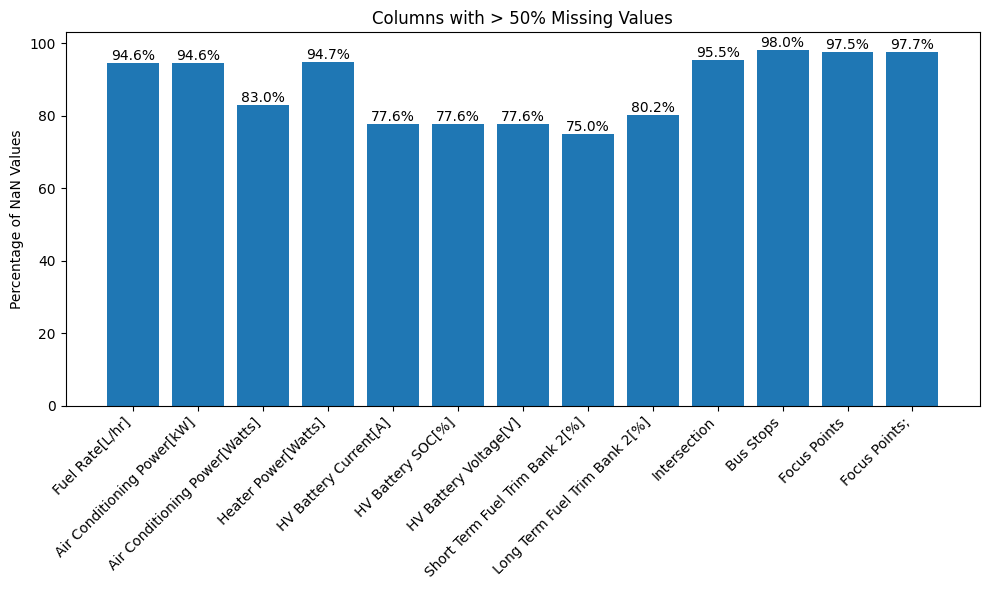

CPU times: total: 7.27 s
Wall time: 7.48 s


In [13]:
%%time
# Drop columns with >50% NaN values
nan_percentages = (raw_df.isna().sum() / len(raw_df)) * 100

# Filter columns with >80% NaN values
high_nan_cols = nan_percentages[nan_percentages > 50]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(high_nan_cols)), high_nan_cols.values)
plt.xticks(range(len(high_nan_cols)), high_nan_cols.index, rotation=45, ha='right')
plt.ylabel('Percentage of NaN Values')  
plt.title('Columns with > 50% Missing Values')

# Add percentage labels on top of bars
for i, v in enumerate(high_nan_cols.values):
    plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

raw_df.drop(columns=high_nan_cols.index, inplace=True)

              VehId          Trip         count
count  24064.000000  24064.000000  24064.000000
mean     394.988697   1444.561212    688.785032
std      146.034011    849.173767    596.433923
min        2.000000      2.000000     13.000000
25%      289.000000    902.000000    282.000000
50%      418.000000   1298.000000    540.000000
75%      522.000000   1830.000000    893.000000
max      610.000000  10896.000000  10813.000000
Trip with most data points: VehId=465.0, Trip=988.0, Count=10813.0
Trip with fewest data points: VehId=592.0, Trip=543.0, Count=13.0

Data point count distribution:
count    24064.000000
mean       688.785032
std        596.433923
min         13.000000
25%        282.000000
50%        540.000000
75%        893.000000
max      10813.000000
Name: count, dtype: float64


,VehId,Trip,count
0,592.0,543.0,13
1,269.0,1529.0,48
2,269.0,1530.0,82
3,438.0,2490.0,101
4,441.0,948.0,101
...,...,...,...
24059,492.0,2778.0,6008
24060,349.0,1555.0,6723
24061,575.0,1639.0,7095
24062,465.0,956.0,9866


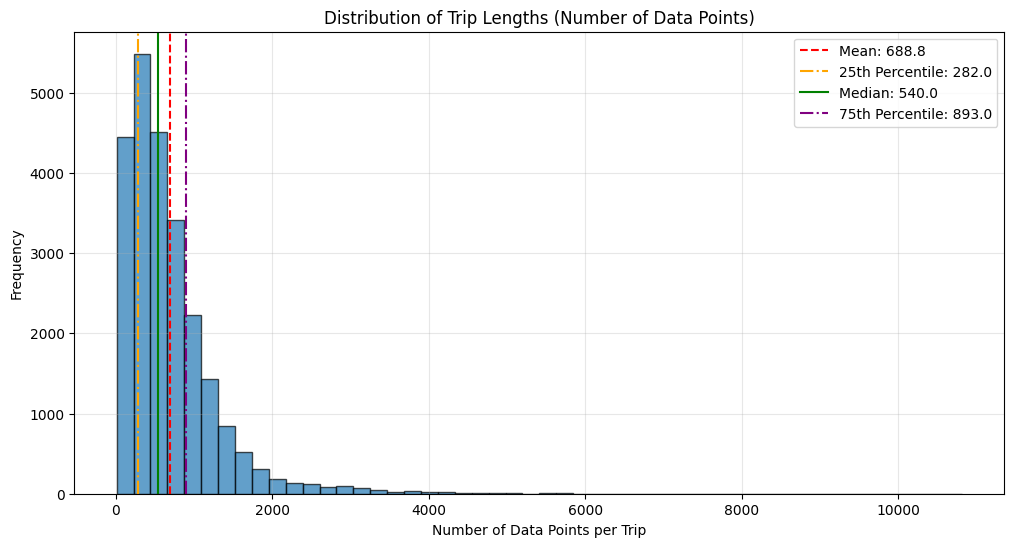

In [14]:
# Group by VehId and Trip, then count the number of rows
tracking_counts = raw_df.groupby(['VehId', 'Trip']).size().reset_index(name='count').sort_values(by='count').reset_index(drop=True)
print(tracking_counts.describe())

# Calculate percentiles for vertical lines
percentile_25 = tracking_counts['count'].quantile(0.25)
percentile_50 = tracking_counts['count'].median()
percentile_75 = tracking_counts['count'].quantile(0.75)

# Plot histogram of trip data point counts
plt.figure(figsize=(12, 6))
plt.hist(tracking_counts['count'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Trip Lengths (Number of Data Points)')
plt.xlabel('Number of Data Points per Trip')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Add vertical lines for mean, median and percentiles
plt.axvline(tracking_counts['count'].mean(), color='red', linestyle='--', 
            label=f'Mean: {tracking_counts["count"].mean():.1f}')
plt.axvline(percentile_25, color='orange', linestyle='-.', 
            label=f'25th Percentile: {percentile_25:.1f}')
plt.axvline(percentile_50, color='green', linestyle='-', 
            label=f'Median: {percentile_50:.1f}')
plt.axvline(percentile_75, color='purple', linestyle='-.', 
            label=f'75th Percentile: {percentile_75:.1f}')
plt.legend()

# Find trips with maximum and minimum data points
max_trip = tracking_counts.loc[tracking_counts['count'].idxmax()]
min_trip = tracking_counts.loc[tracking_counts['count'].idxmin()]

print(f"Trip with most data points: VehId={max_trip['VehId']}, Trip={max_trip['Trip']}, Count={max_trip['count']}")
print(f"Trip with fewest data points: VehId={min_trip['VehId']}, Trip={min_trip['Trip']}, Count={min_trip['count']}")

# Get distribution statistics
print("\nData point count distribution:")
print(tracking_counts['count'].describe())

tracking_counts

In [15]:
import osmnx as ox

# Specify the path to your .osm file
osm_file_path = "DATA/map.osm"

# Load the .osm file
graph = ox.graph_from_xml(osm_file_path)

# Convert the graph to a GeoDataFrame for further analysis
nodes, edges = ox.graph_to_gdfs(graph)

# Display the edges GeoDataFrame
nodes

,y,x,highway,railway,ref,geometry
osmid,,,,,,
62527493,42.281797,-83.759832,NaN,NaN,NaN,POINT (-83.75983 42.2818)
62527499,42.281894,-83.763230,NaN,NaN,NaN,POINT (-83.76323 42.28189)
5352792088,42.277009,-83.763159,NaN,NaN,NaN,POINT (-83.76316 42.27701)
5352792090,42.276958,-83.763146,NaN,NaN,NaN,POINT (-83.76315 42.27696)
5352792096,42.274649,-83.762852,NaN,NaN,NaN,POINT (-83.76285 42.27465)
...,...,...,...,...,...,...
4936161200,42.277986,-83.758416,NaN,NaN,NaN,POINT (-83.75842 42.27799)
4936161202,42.279524,-83.758457,NaN,NaN,NaN,POINT (-83.75846 42.27952)
4936161204,42.278070,-83.758417,NaN,NaN,NaN,POINT (-83.75842 42.27807)


In [16]:
edges

osmid      highway   lanes  \
u          v          key                                                
62527493   7359784515 0                   8728126  residential       2   
62527499   62537396   0                   8726618  residential       2   
5352792088 62486098   0                 442013278    secondary       2   
           5352792090 0                 554671148      footway     NaN   
           62486111   0                 442013278    secondary       2   
...                                           ...          ...     ...   
4936161206 62484277   0                   8722066  residential       2   
4936161207 62486090   0                 420302893     tertiary       3   
           62544806   0    [420302893, 441448231]     tertiary  [3, 2]   
           5352898407 0    [554685025, 503275533]      footway     NaN   
           4936161204 0    [503275531, 503275533]      footway     NaN   

                          maxspeed                  name  oneway  \
u          v          key                                          
62527493   7359784515 0     15 mph         Eighth Street   False   
62527499   62537396   0     25 mph          Crest Avenue   False   
5352792088 62486098   0     30 mph   West Liberty Street   False   
           5352792090 0        NaN                   NaN   False   
           62486111   0     30 mph   West Liberty Street   False   
...                            ...                   ...     ...   
4936161206 62484277   0        NaN     Mulholland Street   False   
4936161207 62486090   0     25 mph  South Seventh Street   False   
           62544806   0     25 mph  South Seventh Street   False   
           5352898407 0        NaN                   NaN   False   
           4936161204 0        NaN                   NaN   False   

                                reversed      length  \
u          v          key                              
62527493   7359784515 0            False  114.215180   
62527499   62537396   0            False  357.880123   
5352792088 62486098   0             True    7.180637   
           5352792090 0            False    5.832030   
           62486111   0            False  468.191305   
...                                  ...         ...   
4936161206 62484277   0            False  315.018029   
4936161207 62486090   0            False    9.575456   
           62544806   0             True  307.272354   
           5352898407 0    [False, True]    7.571493   
           4936161204 0    [False, True]   10.873139   

                                                                    geometry  \
u          v          key                                                      
62527493   7359784515 0    LINESTRING (-83.75983 42.2818, -83.75985 42.28...   
62527499   62537396   0    LINESTRING (-83.76323 42.28189, -83.76323 42.2...   
5352792088 62486098   0    LINESTRING (-83.76316 42.27701, -83.76307 42.2...   
           5352792090 0    LINESTRING (-83.76316 42.27701, -83.76315 42.2...   
           62486111   0    LINESTRING (-83.76316 42.27701, -83.76417 42.2...   
...                                                                      ...   
4936161206 62484277   0    LINESTRING (-83.75733 42.27829, -83.75734 42.2...   
4936161207 62486090   0    LINESTRING (-83.75855 42.27805, -83.75854 42.2...   
           62544806   0    LINESTRING (-83.75855 42.27805, -83.75856 42.2...   
           5352898407 0    LINESTRING (-83.75855 42.27805, -83.75859 42.2...   
           4936161204 0    LINESTRING (-83.75855 42.27805, -83.75846 42.2...   

                          service landuse access  
u          v          key                         
62527493   7359784515 0       NaN     NaN    NaN  
62527499   62537396   0       NaN     NaN    NaN  
5352792088 62486098   0       NaN     NaN    NaN  
           5352792090 0       NaN     NaN    NaN  
           62486111   0       NaN     NaN    NaN  
...                           ...     ...    ...  
4936161206 6248427

In [17]:
import folium
# Create a map centered at the mean coordinates of the nodes
map_center = [nodes['y'].mean(), nodes['x'].mean()]
map_nodes = folium.Map(location=map_center, zoom_start=20)

# Add points to the map
for _, row in nodes.iterrows():
    folium.CircleMarker(
        location=[row['y'], row['x']],
        radius=3,
        color='blue',
        fill=True,
        fillOpacity=0.6
    ).add_to(map_nodes)

# Display the map
map_nodes

In [18]:
class Node:
    def __init__(self, lat, lon, raw_lat, raw_lon, ele):
        self.lat = lat
        self.lon = lon
        self.raw_lat = raw_lat
        self.raw_lon = raw_lon
        self.ele = ele  

    def __str__(self):
        return f"""Node({', '.join(f'{key}="{value}"' for key, value in self.__dict__.items())})"""

    def to_dict(self):
        # Convert the object to a dictionary
        return self.__dict__

class Edge:
    def __init__(self, df):
        start_row = df.sort_values('Timestamp(ms)').iloc[0]
        self.start_date = daynum_to_datetime(start_row['DayNum'])
        self.start_node = Node(
            lat     = start_row['Matchted Latitude[deg]'], 
            lon     = start_row['Matched Longitude[deg]'], 
            raw_lat = start_row['Latitude[deg]'],
            raw_lon = start_row['Longitude[deg]'],
            ele     = start_row['Elevation Smoothed[m]']
            )

        end_row = df.sort_values('Timestamp(ms)').iloc[-1]
        self.end_date = daynum_to_datetime(end_row['DayNum'])
        self.end_node = Node(
            lat     = end_row['Matchted Latitude[deg]'], 
            lon     = end_row['Matched Longitude[deg]'], 
            raw_lat = end_row['Latitude[deg]'],
            raw_lon = end_row['Longitude[deg]'],
            ele     = end_row['Elevation Smoothed[m]'])      

        self.distance = haversine((self.start_node.lat, self.start_node.lon), (self.end_node.lat, self.end_node.lon), unit=Unit.METERS)
        self.time = (end_row['Timestamp(ms)'] - start_row['Timestamp(ms)']) / 1000  # Convert milliseconds to seconds

        self.speed              = float(df['Vehicle Speed[km/h]'].mean())
        self.maf                = float(df['MAF[g/sec]'].mean())
        self.engine_rpm         = float(df['Engine RPM[RPM]'].mean())
        self.absolute_load      = float(df['Absolute Load[%]'].mean())
        self.oat                = float(df['OAT[DegC]'].mean())
        self.stft_bank1         = float(df['Short Term Fuel Trim Bank 1[%]'].mean())
        self.ltft_bank1         = float(df['Long Term Fuel Trim Bank 1[%]'].mean())
        self.gradient           = float(df['Gradient'].mean())
        # self.speed_limit        = float(df['Speed Limit[km/h]'].astype('Int64').mean())
        self.energy_consumption = float(df['Energy_Consumption'].mean())

    def __str__(self):
        return f"""Edge({', '.join(f'{key}="{value}"' for key, value in self.__dict__.items())})"""

    def to_dict(self):
        # Convert the object to a dictionary
        return self.__dict__

class Trip:
    def __init__(self, trip_df, data=None):
        self.vehicle_id = trip_df['VehId'].values[0]
        self.trip_id = str(trip_df['Trip'].values[0]) + "_" + str(trip_df['VehId'].values[0])

        self.start_date = daynum_to_datetime(min(trip_df['DayNum']))
        self.running_time = max(trip_df['Timestamp(ms)']) / 1000
        self.end_date = self.start_date + timedelta(seconds=self.running_time)
        # self.vehicle_type = trip_df['Vehicle_Type'].values[0]
        # self.weight = trip_df['Generalized_Weight'].values[0]
        # self.engine = trip_df['Engine Configuration & Displacement'].values[0]
        
        self.edge_list = []
        sorted_trip_df = trip_df.sort_values('Timestamp(ms)').reset_index(drop=True)
        
        for i in range(len(sorted_trip_df) - 1):
            # Create a segment dataframe with current and next point
            segment_df = sorted_trip_df.iloc[i:i+2]
            self.edge_list.append(Edge(segment_df))
        
        self.node_list = [edge.start_node for edge in self.edge_list] + [self.edge_list[-1].end_node]

    def visualize_trip(self, zoom=14, save_path=None):
        # Create a map centered on the mean latitude and longitude of the trip
        
        center_lat = pd.Series([node.lat for node in self.node_list]).mean()
        center_lon = pd.Series([node.lon for node in self.node_list]).mean()
        trip_map = folium.Map(location=[center_lat, center_lon], zoom_start=zoom)

        folium.PolyLine(
            [[node.raw_lat, node.raw_lon] for node in self.node_list],
            color='orange',
            weight=5,
            opacity=0.7,
            tooltip='raw GPS route'
        ).add_to(trip_map)

        # Add a polyline to show the trip route
        folium.PolyLine(
            [[node.lat, node.lon] for node in self.node_list],
            color='blue',
            weight=3,
            opacity=0.9,
            tooltip='Trip route'
        ).add_to(trip_map)
        
        folium.Marker(
            location=[self.node_list[0].lat, self.node_list[0].lon],
            popup='Start',
            icon=folium.Icon(color='green', icon='play')
        ).add_to(trip_map)

        folium.Marker(
            location=[self.node_list[-1].lat, self.node_list[-1].lon],
            popup='End',
            icon=folium.Icon(color='red', icon='stop')
        ).add_to(trip_map)
        
        return trip_map

    def __str__(self):
        return f"""Trip({', '.join(f'{key}="{value}"' for key, value in self.__dict__.items())})"""

    def to_dict(self):
        # Convert the object to a dictionary
        return self.__dict__

In [19]:
short_trip = Trip(raw_df[(raw_df['VehId'] == 592) & (raw_df['Trip'] == 543)])
short_trip.visualize_trip(zoom=20)


In [20]:
medium_tracking_counts = tracking_counts.iloc[int(len(tracking_counts)/2)]
medium_trip = Trip(raw_df[(raw_df['VehId'] == medium_tracking_counts['VehId']) & (raw_df['Trip'] == medium_tracking_counts['Trip'])])
medium_trip.visualize_trip(zoom=15)


In [21]:
medium_tracking_counts = tracking_counts.iloc[int(len(tracking_counts)/2) - 1]
medium_trip = Trip(raw_df[(raw_df['VehId'] == medium_tracking_counts['VehId']) & (raw_df['Trip'] == medium_tracking_counts['Trip'])])
medium_trip.visualize_trip(zoom=15)


In [22]:
long_trip  = Trip(raw_df[(raw_df['VehId'] == 465) & (raw_df['Trip'] == 988)])
long_trip.visualize_trip()


In [23]:
del short_trip
del medium_trip
del long_trip
del map_nodes
del graph 
del nodes
del edges
del df_list
gc.collect()

843

In [24]:
percentile_25 = float(tracking_counts['count'].quantile(0.25))
percentile_50 = float(tracking_counts['count'].median())
percentile_75 = float(tracking_counts['count'].quantile(0.75))

raw_df = raw_df.merge(tracking_counts, on=['VehId', 'Trip'], how='left')
raw_df = raw_df[(raw_df['count'] > percentile_25) & (raw_df['count'] < percentile_75)]
raw_df.drop(columns=['count'], inplace=True)
print("Dataframe size:", raw_df.shape)
print("Total unique vehicles:", raw_df['VehId'].nunique())
print("Total unique trips:",    raw_df[['VehId','Trip']].drop_duplicates().shape[0])

Dataframe size: (6651945, 23)
Total unique vehicles: 299
Total unique trips: 12021


In [25]:
raw_df = raw_df.merge(df_VehId, on='VehId', how='inner')
raw_df

,DayNum,VehId,Trip,Timestamp(ms),Latitude[deg],Longitude[deg],Vehicle Speed[km/h],MAF[g/sec],Engine RPM[RPM],Absolute Load[%],OAT[DegC],Short Term Fuel Trim Bank 1[%],Long Term Fuel Trim Bank 1[%],Elevation Raw[m],Elevation Smoothed[m],Gradient,Energy_Consumption,Matchted Latitude[deg],Matched Longitude[deg],Match Type,Class of Speed Limit,Speed Limit[km/h],Speed Limit with Direction[km/h],Vehicle_Type,Vehicle Class,Engine Configuration & Displacement,Generalized_Weight
0,1.058991,11.0,1485.0,0.0,42.300565,-83.735444,40.439999,6.13,1336.0,NaN,6.25,NaN,NaN,258.927948,258.927948,0.000000,0.002591,42.300623,-83.735750,0,0.0,40,40.0,PHEV,Car,4-GAS/ELECTRIC 2.0L,4000
1,1.058991,11.0,1485.0,200.0,42.300565,-83.735444,40.439999,4.20,2214.0,NaN,6.25,NaN,NaN,258.927948,258.927948,0.000000,0.002591,42.300623,-83.735750,1,0.0,40,40.0,PHEV,Car,4-GAS/ELECTRIC 2.0L,4000
2,1.058991,11.0,1485.0,300.0,42.300565,-83.735444,40.439999,4.20,2214.0,NaN,6.25,NaN,NaN,258.927948,258.927948,0.000000,0.004696,42.300623,-83.735750,1,0.0,40,40.0,PHEV,Car,4-GAS/ELECTRIC 2.0L,4000
3,1.058991,11.0,1485.0,600.0,42.300565,-83.735444,42.599998,4.20,2214.0,NaN,6.25,NaN,NaN,258.927948,258.927948,0.000000,0.004696,42.300623,-83.735750,1,0.0,40,40.0,PHEV,Car,4-GAS/ELECTRIC 2.0L,4000
4,1.058991,11.0,1485.0,1600.0,42.300565,-83.735444,43.459999,4.20,2214.0,NaN,6.25,NaN,NaN,258.927948,258.927948,0.000000,0.004696,42.300623,-83.735750,1,0.0,40,40.0,PHEV,Car,4-GAS/ELECTRIC 2.0L,4000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065496,374.535685,388.0,2183.0,597000.0,42.279597,-83.750287,23.160000,0.71,0.0,NaN,5.25,0.0,NaN,249.835434,250.538107,0.017723,0.007182,42.279631,-83.750286,1,1.0,56,56.0,PHEV,Car,4-GAS/ELECTRIC 2.0L,4000
1065497,374.535685,388.0,2183.0,598000.0,42.279594,-83.750047,23.840000,0.71,0.0,NaN,5.25,0.0,NaN,251.592117,250.889444,0.000000,0.001940,42.279625,-83.750045,0,1.0,56,56.0,PHEV,Car,4-GAS/ELECTRIC 2.0L,4000
1065498,374.535685,388.0,2183.0,599000.0,42.279594,-83.750047,19.910000,0.71,0.0,NaN,5.25,0.0,NaN,251.592117,251.240781,0.000000,0.000371,42.279625,-83.750045,1,1.0,56,56.0,PHEV,Car,4-GAS/ELECTRIC 2.0L,4000
1065499,374.535685,388.0,2183.0,599800.0,42.279594,-83.750047,19.910000,0.71,0.0,NaN,5.25,0.0,NaN,251.592117,251.592117,0.000000,0.000370,42.279625,-83.750045,1,1.0,56,56.0,PHEV,Car,4-GAS/ELECTRIC 2.0L,4000


In [26]:
# Calculate percentage of null values for each column
null_percentages = (raw_df.isnull().sum() / len(raw_df)) * 100

# Sort from highest to lowest null percentage
sorted_null_percentages = null_percentages.sort_values(ascending=False)

# Display columns with their null percentages
print("Null percentage by column:")
for col, pct in sorted_null_percentages.items():
    if pct > 0:  # Only show columns that have null values
        print(f"{col}: {pct:.2f}%")
        
raw_df.drop(columns=['Latitude[deg]', 'Longitude[deg]', 'Absolute Load[%]', 'Long Term Fuel Trim Bank 1[%]', 'Short Term Fuel Trim Bank 1[%]', 'MAF[g/sec]', 'Vehicle Class', 'Elevation Raw[m]','Match Type', 'Class of Speed Limit', 'Speed Limit with Direction[km/h]'], inplace=True)
raw_df.dropna(how='any', axis=0)
raw_df.reset_index(drop=True, inplace=True)

Null percentage by column:
Absolute Load[%]: 93.54%
Long Term Fuel Trim Bank 1[%]: 93.54%
Short Term Fuel Trim Bank 1[%]: 73.14%
MAF[g/sec]: 39.57%
Engine RPM[RPM]: 11.82%
OAT[DegC]: 5.88%
Gradient: 1.63%
Class of Speed Limit: 1.31%
Speed Limit[km/h]: 1.31%
Speed Limit with Direction[km/h]: 1.31%


In [27]:
raw_df['VehId'] = raw_df['VehId'].astype('Int64')
raw_df['Trip']  = raw_df['Trip'].astype('Int64')
raw_df['Timestamp(ms)'] = raw_df['Timestamp(ms)'].astype('Int64')
raw_df['Engine RPM[RPM]'] = raw_df['Engine RPM[RPM]'].astype('Int64')
raw_df.to_csv("DATA/raw_data.csv", index=False)

In [28]:
# Get initial memory info
before = len(gc.get_objects())
print(f"Objects before: {before}")
# Clear large dataframes and lists

del raw_df
del df_IceHev
del df_PhevEv
del df_VehId
del df
del high_nan_cols
del nan_percentages

# Force garbage collection
gc.collect()

# Get memory info after cleanup
after = len(gc.get_objects())
print(f"Objects after: {after}")

Objects before: 483696
Objects after: 483544


## 2. Training

In [29]:
pd.read_csv("DATA/raw_data.csv", low_memory=False).head()

,DayNum,VehId,Trip,Timestamp(ms),Vehicle Speed[km/h],Engine RPM[RPM],OAT[DegC],Elevation Smoothed[m],Gradient,Energy_Consumption,Matchted Latitude[deg],Matched Longitude[deg],Speed Limit[km/h],Vehicle_Type,Engine Configuration & Displacement,Generalized_Weight
0,1.058991,11,1485,0,40.439999,1336.0,6.25,258.927948,0.0,0.002591,42.300623,-83.73575,40,PHEV,4-GAS/ELECTRIC 2.0L,4000
1,1.058991,11,1485,200,40.439999,2214.0,6.25,258.927948,0.0,0.002591,42.300623,-83.73575,40,PHEV,4-GAS/ELECTRIC 2.0L,4000
2,1.058991,11,1485,300,40.439999,2214.0,6.25,258.927948,0.0,0.004696,42.300623,-83.73575,40,PHEV,4-GAS/ELECTRIC 2.0L,4000
3,1.058991,11,1485,600,42.599998,2214.0,6.25,258.927948,0.0,0.004696,42.300623,-83.73575,40,PHEV,4-GAS/ELECTRIC 2.0L,4000
4,1.058991,11,1485,1600,43.459999,2214.0,6.25,258.927948,0.0,0.004696,42.300623,-83.73575,40,PHEV,4-GAS/ELECTRIC 2.0L,4000


In [30]:
full_df = pd.read_csv("DATA/raw_data.csv", low_memory=False)

print("Dataframe shape:", full_df.shape)
print("Total unique vehicles:", full_df['VehId'].nunique())
print("Total unique trips:",    full_df[['VehId','Trip']].drop_duplicates().shape[0])

full_df.rename(columns={'Matchted Latitude[deg]': 'Matched Latitude[deg]'}, inplace=True)
# full_df.drop(columns=['Latitude[deg]', 'Longitude[deg]'], inplace=True)
print(full_df.columns)

Dataframe shape: (1065501, 16)
Total unique vehicles: 32
Total unique trips: 1836
Index(['DayNum', 'VehId', 'Trip', 'Timestamp(ms)', 'Vehicle Speed[km/h]',
       'Engine RPM[RPM]', 'OAT[DegC]', 'Elevation Smoothed[m]', 'Gradient',
       'Energy_Consumption', 'Matched Latitude[deg]', 'Matched Longitude[deg]',
       'Speed Limit[km/h]', 'Vehicle_Type',
       'Engine Configuration & Displacement', 'Generalized_Weight'],
      dtype='object')


In [31]:
def get_hour_category(daynum):
    """
    Convert a DayNum float to a datetime object.
    DayNum 1 corresponds to Nov 1st, 2017, 00:00:00.
    """
    # Reference date: DayNum 1 = Nov 1st, 2017, 00:00:00
    reference_date = datetime(2017, 11, 1, 0, 0, 0)

    # Calculate the timedelta from the reference date
    delta = timedelta(days=daynum - 1)
    # Add the timedelta to the reference date
    result_datetime = reference_date + delta
    # Extract the hour from the datetime
    hour = result_datetime.hour

    # Categorize based on hour ranges
    if 7 <= hour < 17:  # 7am-5pm 
        return 1 # peak hour
    elif 17 <= hour < 21:  # 5pm-9pm
        return 2 # off-peak hour
    else:  # Other hours
        return 3 # night hour

full_df['Energy_Consumption'] = abs(full_df['Energy_Consumption'])
full_df['time_category'] = full_df['DayNum'].apply(get_hour_category)
full_df['TripID'] = full_df['VehId'].astype(str) + "_" + full_df['Trip'].astype(str) 
full_df['Step'] = full_df.sort_values(['TripID', 'Timestamp(ms)']).groupby(['TripID']).cumcount() 
full_df.drop(columns=['DayNum', 'Trip'], inplace=True)

column_list = full_df.columns.to_list()
other_cols = [col for col in column_list if col not in ['TripID', 'Step', 'Energy_Consumption']]
column_list = ['TripID', 'Step', 'Energy_Consumption'] + other_cols
full_df = full_df[column_list]

full_df['Speed Limit[km/h]'] = full_df['Speed Limit[km/h]'].replace('48-40', '48')
full_df['Speed Limit[km/h]'] = full_df['Speed Limit[km/h]'].replace('48-72', '72')
full_df['Speed Limit[km/h]'] = full_df['Speed Limit[km/h]'].replace('40-48', '48')
full_df['Speed Limit[km/h]'] = full_df['Speed Limit[km/h]'].replace('56-72', '72')
full_df

,TripID,Step,Energy_Consumption,VehId,Timestamp(ms),Vehicle Speed[km/h],Engine RPM[RPM],OAT[DegC],Elevation Smoothed[m],Gradient,Matched Latitude[deg],Matched Longitude[deg],Speed Limit[km/h],Vehicle_Type,Engine Configuration & Displacement,Generalized_Weight,time_category
0,11_1485,0,0.002591,11,0,40.439999,1336.0,6.25,258.927948,0.000000,42.300623,-83.735750,40,PHEV,4-GAS/ELECTRIC 2.0L,4000,3
1,11_1485,1,0.002591,11,200,40.439999,2214.0,6.25,258.927948,0.000000,42.300623,-83.735750,40,PHEV,4-GAS/ELECTRIC 2.0L,4000,3
2,11_1485,2,0.004696,11,300,40.439999,2214.0,6.25,258.927948,0.000000,42.300623,-83.735750,40,PHEV,4-GAS/ELECTRIC 2.0L,4000,3
3,11_1485,3,0.004696,11,600,42.599998,2214.0,6.25,258.927948,0.000000,42.300623,-83.735750,40,PHEV,4-GAS/ELECTRIC 2.0L,4000,3
4,11_1485,4,0.004696,11,1600,43.459999,2214.0,6.25,258.927948,0.000000,42.300623,-83.735750,40,PHEV,4-GAS/ELECTRIC 2.0L,4000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065496,388_2183,782,0.007182,388,597000,23.160000,0.0,5.25,250.538107,0.017723,42.279631,-83.750286,56,PHEV,4-GAS/ELECTRIC 2.0L,4000,1
1065497,388_2183,783,0.001940,388,598000,23.840000,0.0,5.25,250.889444,0.000000,42.279625,-83.750045,56,PHEV,4-GAS/ELECTRIC 2.0L,4000,1
1065498,388_2183,784,0.000371,388,599000,19.910000,0.0,5.25,251.240781,0.000000,42.279625,-83.750045,56,PHEV,4-GAS/ELECTRIC 2.0L,4000,1
1065499,388_2183,785,0.000370,388,599800,19.910000,0.0,5.25,251.592117,0.000000,42.279625,-83.750045,56,PHEV,4-GAS/ELECTRIC 2.0L,4000,1


In [32]:

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth specified in decimal degrees using the haversine formula.
    """
    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # differences
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    # haversine formula 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371  # Radius of Earth in kilometers.
    return c * r

aggregations = {
    'Energy_Consumption': 'sum',                   # Total energy consumed over the trip
    'VehId': 'first',                              # Vehicle ID
    'Vehicle Speed[km/h]': 'mean',                 # Average vehicle speed
    'Engine RPM[RPM]': 'mean',                     # Average engine RPM
    'OAT[DegC]': 'mean',                           # Average outside air temperature
    'Elevation Smoothed[m]': 'mean',               # Average elevation
    'Timestamp(ms)': ['min', 'max'],               # Start and end timestamps for time duration calculation
    'Gradient': 'mean',                            # Average road gradient
    'Matched Latitude[deg]': ['first', 'last'],    # Starting and ending latitude
    'Matched Longitude[deg]': ['first', 'last']    # Starting and ending longitude
}

# Group by TripID and apply the aggregation
trip_df = full_df.groupby('TripID').agg(aggregations)

# -------------------------
# Step 3: Clean Up the Aggregated DataFrame Columns
# -------------------------
# The aggregation produces a MultiIndex on the columns. Flatten them for easier handling.
trip_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in trip_df.columns.values]

# -------------------------
# Step 4: Calculate Total Time for Each Trip
# -------------------------
# Here we compute the trip duration by taking the difference of max and min timestamps.
# Timestamps are in milliseconds. Dividing by 1000 converts them to seconds.
trip_df['total_time_sec'] = (trip_df['Timestamp(ms)_max'] - trip_df['Timestamp(ms)_min']) / 1000.0

# -------------------------
# Step 5: Calculate Total Distance for Each Trip
# -------------------------
# Use the haversine function to calculate the distance between the starting position and the ending position.
trip_df['total_distance_km'] = trip_df.apply(
    lambda row: haversine(row['Matched Latitude[deg]_first'],
                        row['Matched Longitude[deg]_first'],
                        row['Matched Latitude[deg]_last'],
                        row['Matched Longitude[deg]_last']),
    axis=1
)

trip_df = trip_df.reset_index().sort_values(by=['VehId_first', 'TripID'])
trip_df

,TripID,Energy_Consumption_sum,VehId_first,Vehicle Speed[km/h]_mean,Engine RPM[RPM]_mean,OAT[DegC]_mean,Elevation Smoothed[m]_mean,Timestamp(ms)_min,Timestamp(ms)_max,Gradient_mean,Matched Latitude[deg]_first,Matched Latitude[deg]_last,Matched Longitude[deg]_first,Matched Longitude[deg]_last,total_time_sec,total_distance_km
229,2_1028,1.756126,2,30.365419,1323.980392,-9.454545,250.243461,0,430000,0.000306,42.287563,42.295420,-83.733259,-83.705210,430.0,2.467028
230,2_1049,1.507148,2,30.730838,1270.682709,-12.468806,252.071630,0,427700,0.000206,42.287601,42.295387,-83.733304,-83.705036,427.7,2.481117
231,2_694,1.206319,2,33.261324,1206.770035,NaN,252.024601,0,445400,-0.000373,42.316068,42.286788,-83.734120,-83.732653,445.4,3.258022
232,2_714,1.671851,2,34.424797,1389.603659,NaN,250.419953,0,335100,0.000353,42.287723,42.295388,-83.733257,-83.705041,335.1,2.472437
233,2_760,14.267673,2,96.843318,1954.511521,NaN,260.953119,0,669900,0.000061,42.242172,42.309050,-83.767366,-83.678337,669.9,10.438156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764,569_813,1.000233,569,36.038009,0.000000,-9.263323,275.443862,0,289800,0.000027,42.309290,42.302600,-83.677480,-83.704039,289.8,2.307300
1765,569_827,2.496865,569,48.517694,520.603960,-12.917079,257.581173,0,758900,-0.000135,42.316512,42.257212,-83.706723,-83.696009,758.9,6.652498
1766,569_828,2.042484,569,41.893957,246.202212,-14.176935,267.839988,0,511900,0.000162,42.259082,42.267359,-83.709345,-83.770362,511.9,5.104817
1767,569_855,1.378864,569,40.224067,0.000000,2.500000,264.354417,0,318700,0.000157,42.280363,42.280519,-83.744122,-83.779595,318.7,2.918372


In [33]:
mean_attributes = ['Vehicle Speed[km/h]_mean', 
                'Engine RPM[RPM]_mean', 
                'OAT[DegC]_mean', 
                'Elevation Smoothed[m]_mean', 
                'Gradient_mean']

for metric in mean_attributes:
    cum_col = metric + '_cumavg_prev'
    trip_df[cum_col] = (trip_df.groupby('VehId_first')[metric]
                                .apply(lambda x: x.expanding(min_periods=1).mean().shift())
                                .reset_index(level=0, drop=True))
    # Optionally, you could fill NaN (e.g. for the first trip) with a default value, say 0:
    # trip_df[cum_col] = trip_df[cum_col].fillna(0)
    trip_df[cum_col].fillna(trip_df[cum_col].mean(), inplace=True)

# ------------------------------
# 3. Combine individual metric cumulative averages into an overall average performance.
#
# This overall column averages the previous values of the selected performance metrics.
# ------------------------------
cumavg_columns = [metric + '_cumavg_prev' for metric in mean_attributes]
trip_df['avg_performance_prev'] = trip_df[cumavg_columns].mean(axis=1)

# ------------------------------
# 4. Preview the resulting DataFrame
# ------------------------------
trip_df

C:\Users\MinhVu\AppData\Local\Temp\ipykernel_29460\4007054660.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trip_df[cum_col].fillna(trip_df[cum_col].mean(), inplace=True)
C:\Users\MinhVu\AppData\Local\Temp\ipykernel_29460\4007054660.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

,TripID,Energy_Consumption_sum,VehId_first,Vehicle Speed[km/h]_mean,Engine RPM[RPM]_mean,OAT[DegC]_mean,Elevation Smoothed[m]_mean,Timestamp(ms)_min,Timestamp(ms)_max,Gradient_mean,Matched Latitude[deg]_first,Matched Latitude[deg]_last,Matched Longitude[deg]_first,Matched Longitude[deg]_last,total_time_sec,total_distance_km,Vehicle Speed[km/h]_mean_cumavg_prev,Engine RPM[RPM]_mean_cumavg_prev,OAT[DegC]_mean_cumavg_prev,Elevation Smoothed[m]_mean_cumavg_prev,Gradient_mean_cumavg_prev,avg_performance_prev
229,2_1028,1.756126,2,30.365419,1323.980392,-9.454545,250.243461,0,430000,0.000306,42.287563,42.295420,-83.733259,-83.705210,430.0,2.467028,42.407395,389.421526,8.857008,260.927699,0.000014,140.322728
230,2_1049,1.507148,2,30.730838,1270.682709,-12.468806,252.071630,0,427700,0.000206,42.287601,42.295387,-83.733304,-83.705036,427.7,2.481117,30.365419,1323.980392,-9.454545,250.243461,0.000306,319.027007
231,2_694,1.206319,2,33.261324,1206.770035,NaN,252.024601,0,445400,-0.000373,42.316068,42.286788,-83.734120,-83.732653,445.4,3.258022,30.548128,1297.331551,-10.961676,251.157545,0.000256,313.615161
232,2_714,1.671851,2,34.424797,1389.603659,NaN,250.419953,0,335100,0.000353,42.287723,42.295388,-83.733257,-83.705041,335.1,2.472437,31.452527,1267.144379,-10.961676,251.446564,0.000046,307.816368
233,2_760,14.267673,2,96.843318,1954.511521,NaN,260.953119,0,669900,0.000061,42.242172,42.309050,-83.767366,-83.678337,669.9,10.438156,32.195594,1297.759199,-10.961676,251.189911,0.000123,314.036630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764,569_813,1.000233,569,36.038009,0.000000,-9.263323,275.443862,0,289800,0.000027,42.309290,42.302600,-83.677480,-83.704039,289.8,2.307300,42.209365,161.044523,11.338972,265.646821,0.000054,96.047947
1765,569_827,2.496865,569,48.517694,520.603960,-12.917079,257.581173,0,758900,-0.000135,42.316512,42.257212,-83.706723,-83.696009,758.9,6.652498,42.145080,159.366976,11.124365,265.748873,0.000054,95.677070
1766,569_828,2.042484,569,41.893957,246.202212,-14.176935,267.839988,0,511900,0.000162,42.259082,42.267359,-83.709345,-83.770362,511.9,5.104817,42.210777,163.091068,10.876515,265.664670,0.000052,96.368617
1767,569_855,1.378864,569,40.224067,0.000000,2.500000,264.354417,0,318700,0.000157,42.280363,42.280519,-83.744122,-83.779595,318.7,2.918372,42.207545,163.939141,10.620868,265.686867,0.000053,96.490895


In [34]:
# trip_df[['Matched Latitude[deg]_first', 'Matched Longitude[deg]_first', 'Matched Latitude[deg]_last', 'Matched Longitude[deg]_last']].value_counts()

In [35]:
full_trip_df = pd.merge(full_df, trip_df, on='TripID', how='left')
full_trip_df.drop(columns=['Timestamp(ms)_min', 'Timestamp(ms)_max'], inplace=True)
full_trip_df

,TripID,Step,Energy_Consumption,VehId,Timestamp(ms),Vehicle Speed[km/h],Engine RPM[RPM],OAT[DegC],Elevation Smoothed[m],Gradient,Matched Latitude[deg],Matched Longitude[deg],Speed Limit[km/h],Vehicle_Type,Engine Configuration & Displacement,Generalized_Weight,time_category,Energy_Consumption_sum,VehId_first,Vehicle Speed[km/h]_mean,Engine RPM[RPM]_mean,OAT[DegC]_mean,Elevation Smoothed[m]_mean,Gradient_mean,Matched Latitude[deg]_first,Matched Latitude[deg]_last,Matched Longitude[deg]_first,Matched Longitude[deg]_last,total_time_sec,total_distance_km,Vehicle Speed[km/h]_mean_cumavg_prev,Engine RPM[RPM]_mean_cumavg_prev,OAT[DegC]_mean_cumavg_prev,Elevation Smoothed[m]_mean_cumavg_prev,Gradient_mean_cumavg_prev,avg_performance_prev
0,11_1485,0,0.002591,11,0,40.439999,1336.0,6.25,258.927948,0.000000,42.300623,-83.735750,40,PHEV,4-GAS/ELECTRIC 2.0L,4000,3,0.933848,11,51.039873,1199.883838,5.604167,277.363848,0.000246,42.300623,42.317947,-83.735750,-83.717219,231.5,2.456182,42.407395,389.421526,8.857008,260.927699,0.000014,140.322728
1,11_1485,1,0.002591,11,200,40.439999,2214.0,6.25,258.927948,0.000000,42.300623,-83.735750,40,PHEV,4-GAS/ELECTRIC 2.0L,4000,3,0.933848,11,51.039873,1199.883838,5.604167,277.363848,0.000246,42.300623,42.317947,-83.735750,-83.717219,231.5,2.456182,42.407395,389.421526,8.857008,260.927699,0.000014,140.322728
2,11_1485,2,0.004696,11,300,40.439999,2214.0,6.25,258.927948,0.000000,42.300623,-83.735750,40,PHEV,4-GAS/ELECTRIC 2.0L,4000,3,0.933848,11,51.039873,1199.883838,5.604167,277.363848,0.000246,42.300623,42.317947,-83.735750,-83.717219,231.5,2.456182,42.407395,389.421526,8.857008,260.927699,0.000014,140.322728
3,11_1485,3,0.004696,11,600,42.599998,2214.0,6.25,258.927948,0.000000,42.300623,-83.735750,40,PHEV,4-GAS/ELECTRIC 2.0L,4000,3,0.933848,11,51.039873,1199.883838,5.604167,277.363848,0.000246,42.300623,42.317947,-83.735750,-83.717219,231.5,2.456182,42.407395,389.421526,8.857008,260.927699,0.000014,140.322728
4,11_1485,4,0.004696,11,1600,43.459999,2214.0,6.25,258.927948,0.000000,42.300623,-83.735750,40,PHEV,4-GAS/ELECTRIC 2.0L,4000,3,0.933848,11,51.039873,1199.883838,5.604167,277.363848,0.000246,42.300623,42.317947,-83.735750,-83.717219,231.5,2.456182,42.407395,389.421526,8.857008,260.927699,0.000014,140.322728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065496,388_2183,782,0.007182,388,597000,23.160000,0.0,5.25,250.538107,0.017723,42.279631,-83.750286,56,PHEV,4-GAS/ELECTRIC 2.0L,4000,1,2.079885,388,26.596492,0.000000,5.140089,273.758944,-0.000137,42.253679,42.279625,-83.766817,-83.750045,600.1,3.198172,46.941902,375.658220,15.008656,257.502572,-0.000016,139.022267
1065497,388_2183,783,0.001940,388,598000,23.840000,0.0,5.25,250.889444,0.000000,42.279625,-83.750045,56,PHEV,4-GAS/ELECTRIC 2.0L,4000,1,2.079885,388,26.596492,0.000000,5.140089,273.758944,-0.000137,42.253679,42.279625,-83.766817,-83.750045,600.1,3.198172,46.941902,375.658220,15.008656,257.502572,-0.000016,139.022267
1065498,388_2183,784,0.000371,388,599000,19.910000,0.0,5.25,251.240781,0.000000,42.279625,-83.750045,56,PHEV,4-GAS/ELECTRIC 2.0L,4000,1,2.079885,388,26.596492,0.000000,5.140089,273.758944,-0.000137,42.253679,42.279625,-83.766817,-83.750045,600.1,3.198172,46.941902,375.658220,15.008656,257.502572,-0.000016,139.022267
1065499,388_2183,785,0.000370,388,599800,19.910000,0.0,5.25,251.592117,0.000000,42.279625,-83.750045,56,PHEV,4-GAS/ELECTRIC 2.0L,4000,1,2.079885,388,26.596492,0.000000,5.140089,273.758944,-0.000137,42.253679,42.279625,-83.766817,-83.750045,600.1,3.198172,46.941902,375.658220,15.008656,257.502572,-0.000016,139.022267


### 2.1 approach 01: Step by step

In [36]:
pyperclip.copy(full_trip_df.columns.to_list())

In [37]:

numeric_cols = ['Energy_Consumption', 
                'Vehicle Speed[km/h]', 
                'Engine RPM[RPM]', 
                'OAT[DegC]', 
                'Elevation Smoothed[m]', 
                'Gradient',
                'Matched Latitude[deg]', 
                'Matched Longitude[deg]', 
                'Speed Limit[km/h]', 
                'Generalized_Weight']

categorical_cols = ['Vehicle_Type', 'Engine Configuration & Displacement', 'time_category']

# Make a copy of the DataFrame.
full_df = full_trip_df.copy()

# Scale numeric features.
scaler = StandardScaler()
full_df[numeric_cols] = scaler.fit_transform(full_df[numeric_cols])

# One-hot encode categorical features.
full_df = pd.get_dummies(full_df, columns=categorical_cols, dtype=float)

# If necessary, reindex the DataFrame so that node indices go from 0 to N-1.
full_df = full_df.reset_index(drop=True)

#######################################
# STEP 2: Build Graph Edges
#######################################
# We assume each row is a snapshot with a "TripID" and a "Step" column. 
# For every trip (each unique TripID), we connect consecutive snapshots.
edge_list = []

# Group by TripID and sort each group by "Step" (or by "Timestamp(ms)" if preferred).
for trip_id, group in tqdm(full_df.groupby('TripID')):
    group_sorted = group.sort_values(by='Step')
    indices = group_sorted.index.to_list()  # these indices are now 0...N-1 in the reindexed full_df
    # Connect each snapshot to its next snapshot.
    for i in range(len(indices) - 1):
        u = indices[i]
        v = indices[i + 1]
        # Add edge from u to v and from v to u (for undirected graph).
        edge_list.append([u, v])
        edge_list.append([v, u])
        
# Convert the edge list to a tensor of shape [2, num_edges].
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

#######################################
# STEP 3: Prepare Node Features and Target
#######################################
# Define the input features and target.
feature_cols = [
    'VehId',  # vehicle identifier; if not numeric already, convert as needed.
    'Matched Latitude[deg]_first',
    'Matched Latitude[deg]_last',
    'Matched Longitude[deg]_first',
    'Matched Longitude[deg]_last',
    'total_time_sec',
    'total_distance_km',
    'Vehicle Speed[km/h]_mean_cumavg_prev',
    'Engine RPM[RPM]_mean_cumavg_prev',
    'OAT[DegC]_mean_cumavg_prev',
    'Elevation Smoothed[m]_mean_cumavg_prev',
    'Gradient_mean_cumavg_prev',
    'avg_performance_prev'
]

target_col = 'Energy_Consumption'

# Extract features and target.
# Note: Ensure these columns already exist in full_df (e.g., from prior aggregation steps).
X = full_df[feature_cols].copy()
y_series = full_df[target_col].copy()

# Convert to torch tensors.
x = torch.tensor(X.values, dtype=torch.float)
y = torch.tensor(y_series.values, dtype=torch.float)

#######################################
# STEP 4: Create PyG Data Object & Split Data
#######################################
data = Data(x=x, edge_index=edge_index, y=y)

# Split nodes (i.e. rows) into training (70%), validation (15%), and test (15%).
num_nodes = data.num_nodes
indices = np.random.permutation(num_nodes)
train_size = int(0.70 * num_nodes)
valid_size = int(0.15 * num_nodes)

train_idx = indices[:train_size]
valid_idx = indices[train_size:train_size+valid_size]
test_idx  = indices[train_size+valid_size:]

# Create boolean masks.
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
valid_mask = torch.zeros(num_nodes, dtype=torch.bool)
valid_mask[valid_idx] = True
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[test_idx] = True

# Attach masks to the data object.
data.train_mask = train_mask
data.valid_mask = valid_mask
data.test_mask = test_mask

100%|██████████| 1836/1836 [00:03<00:00, 547.46it/s]


In [ ]:
#######################################
# STEP 5: Define Two GNN Models: Simple GCN and GraphSAGE
#######################################
# Model 1: Simple GCN Model using two GCNConv layers.
class GCNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.linear = nn.Linear(hidden_channels, 1)  # single regression output
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.linear(x)
        return x.view(-1)

# Model 2: GraphSAGE Model using two SAGEConv layers.
class GraphSAGEModel(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GraphSAGEModel, self).__init__()
        self.sage1 = SAGEConv(in_channels, hidden_channels)
        self.sage2 = SAGEConv(hidden_channels, hidden_channels)
        self.linear = nn.Linear(hidden_channels, 1)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.sage1(x, edge_index)
        x = torch.relu(x)
        x = self.sage2(x, edge_index)
        x = torch.relu(x)
        x = self.linear(x)
        return x.view(-1)

# Set hyperparameters.
in_channels = x.shape[1]
hidden_channels = 32

# Instantiate the models.
gcn_model = GCNModel(in_channels, hidden_channels)
sage_model = GraphSAGEModel(in_channels, hidden_channels)

# Define loss function and optimizers.
criterion = nn.MSELoss()
optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=0.01)
optimizer_sage = optim.Adam(sage_model.parameters(), lr=0.01)

#######################################
# STEP 6: Training and Evaluation Functions
#######################################
def train(model, optimizer, data, mask):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[mask], data.y[mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        loss_value = criterion(out[mask], data.y[mask]).item()
        preds = out[mask].cpu().numpy()
        targets = data.y[mask].cpu().numpy()
        mse = mean_squared_error(targets, preds)
        mae = mean_absolute_error(targets, preds)
        r2 = r2_score(targets, preds)
    return loss_value, mse, mae, r2

#######################################
# STEP 7: Train Both Models
#######################################
num_epochs = 100

# Train the GCN model.
print("Training GCN Model")
for epoch in tqdm(range(num_epochs)):
    loss = train(gcn_model, optimizer_gcn, data, data.train_mask)
    if epoch % 20 == 0:
        val_loss, val_mse, val_mae, val_r2 = evaluate(gcn_model, data, data.valid_mask)
        print(f"GCN Epoch {epoch:03d} | Train Loss: {loss:.4f} | Val Loss: {val_loss:.4f} | Val MSE: {val_mse:.4f}")

# Train the GraphSAGE model.
print("\nTraining GraphSAGE Model")
for epoch in tqdm(range(num_epochs)):
    loss = train(sage_model, optimizer_sage, data, data.train_mask)
    if epoch % 20 == 0:
        val_loss, val_mse, val_mae, val_r2 = evaluate(sage_model, data, data.valid_mask)
        print(f"SAGE Epoch {epoch:03d} | Train Loss: {loss:.4f} | Val Loss: {val_loss:.4f} | Val MSE: {val_mse:.4f}")

#######################################
# STEP 8: Predict on Test Set and Evaluate, Then Compare Both Models
#######################################
gcn_test_loss, gcn_test_mse, gcn_test_mae, gcn_test_r2 = evaluate(gcn_model, data, data.test_mask)
sage_test_loss, sage_test_mse, sage_test_mae, sage_test_r2 = evaluate(sage_model, data, data.test_mask)

print("\nTest Evaluation Metrics:")
print("GCN Model:")
print(f"  MSE: {gcn_test_mse:.4f}, MAE: {gcn_test_mae:.4f}, R²: {gcn_test_r2:.4f}")
print("GraphSAGE Model:")
print(f"  MSE: {sage_test_mse:.4f}, MAE: {sage_test_mae:.4f}, R²: {sage_test_r2:.4f}")

# Optionally, print the first few predictions from both models for side-by-side comparison.
with torch.no_grad():
    gcn_preds = gcn_model(data)[data.test_mask].cpu().numpy()
    sage_preds = sage_model(data)[data.test_mask].cpu().numpy()
    true_values = data.y[data.test_mask].cpu().numpy()

print("\nComparison of Predictions on Test Set (first 10 samples):")
for i in range(min(10, len(true_values))):
    print(f"True: {true_values[i]:.4f}, GCN Pred: {gcn_preds[i]:.4f}, GraphSAGE Pred: {sage_preds[i]:.4f}")


Training GCN Model


  1%|          | 1/100 [00:04<07:07,  4.32s/it]

GCN Epoch 000 | Train Loss: 6577.8716 | Val Loss: 424.5371 | Val MSE: 424.5370


 21%|██        | 21/100 [01:12<04:48,  3.65s/it]

GCN Epoch 020 | Train Loss: 15.0775 | Val Loss: 33.6739 | Val MSE: 33.6739


 41%|████      | 41/100 [02:15<03:29,  3.55s/it]

GCN Epoch 040 | Train Loss: 4.6420 | Val Loss: 4.1390 | Val MSE: 4.1390


 61%|██████    | 61/100 [03:25<02:54,  4.47s/it]

GCN Epoch 060 | Train Loss: 2.7008 | Val Loss: 2.4414 | Val MSE: 2.4414


 81%|████████  | 81/100 [04:32<01:11,  3.78s/it]

GCN Epoch 080 | Train Loss: 2.0280 | Val Loss: 2.0168 | Val MSE: 2.0168


100%|██████████| 100/100 [05:34<00:00,  3.34s/it]



Training GraphSAGE Model


  1%|          | 1/100 [00:02<04:54,  2.98s/it]

SAGE Epoch 000 | Train Loss: 3995.8352 | Val Loss: 15755.0977 | Val MSE: 15755.0996


 21%|██        | 21/100 [00:42<02:42,  2.06s/it]

SAGE Epoch 020 | Train Loss: 99.8591 | Val Loss: 66.0452 | Val MSE: 66.0452


 41%|████      | 41/100 [01:22<02:05,  2.13s/it]

SAGE Epoch 040 | Train Loss: 8.7499 | Val Loss: 7.4494 | Val MSE: 7.4494


 61%|██████    | 61/100 [01:56<01:15,  1.94s/it]

SAGE Epoch 060 | Train Loss: 4.1322 | Val Loss: 3.8759 | Val MSE: 3.8759


 81%|████████  | 81/100 [02:55<01:00,  3.17s/it]

SAGE Epoch 080 | Train Loss: 2.7308 | Val Loss: 2.6575 | Val MSE: 2.6575


100%|██████████| 100/100 [03:32<00:00,  2.13s/it]



Test Evaluation Metrics:
GCN Model:
  MSE: 1.7962, MAE: 1.0326, R²: -0.7515
GraphSAGE Model:
  MSE: 2.1194, MAE: 1.1286, R²: -1.0667

Comparison of Predictions on Test Set (first 10 samples):
True: 0.6016, GCN Pred: -0.7694, GraphSAGE Pred: -2.1451
True: 0.6016, GCN Pred: -0.7694, GraphSAGE Pred: -2.1451
True: -0.8625, GCN Pred: -0.7694, GraphSAGE Pred: -2.1451
True: -0.2951, GCN Pred: -0.7694, GraphSAGE Pred: -2.1451
True: 0.5292, GCN Pred: -0.7694, GraphSAGE Pred: -2.1451
True: 0.5292, GCN Pred: -0.7694, GraphSAGE Pred: -2.1451
True: -0.4139, GCN Pred: -0.7694, GraphSAGE Pred: -2.1451
True: -0.4359, GCN Pred: -0.7694, GraphSAGE Pred: -2.1451
True: 1.1292, GCN Pred: -0.7694, GraphSAGE Pred: -2.1451
True: -0.6311, GCN Pred: -0.7694, GraphSAGE Pred: -2.1451


### 2.2 approach 02: Combined

In [39]:
del full_df
full_df = full_trip_df[:int(len(full_trip_df)/4)].copy()
del trip_df
del full_trip_df
gc.collect

<function gc.collect(generation=2)>

In [40]:
# Define numeric and categorical columns.
numeric_cols = ['Energy_Consumption', 
                'Vehicle Speed[km/h]', 
                'Engine RPM[RPM]', 
                'OAT[DegC]', 
                'Elevation Smoothed[m]', 
                'Gradient',
                'Matched Latitude[deg]', 
                'Matched Longitude[deg]', 
                'Speed Limit[km/h]', 
                'Generalized_Weight']

categorical_cols = ['Vehicle_Type', 'Engine Configuration & Displacement', 'time_category']

# --- Memory Optimization Step 1: Scale numeric features and downcast to float32 ---
scaler = StandardScaler()
# Fit and transform, then downcast to float32.
full_df[numeric_cols] = scaler.fit_transform(full_df[numeric_cols]).astype(np.float32)

# --- Memory Optimization Step 2: One-hot encode categorical features as float32 ---
full_df = pd.get_dummies(full_df, columns=categorical_cols, dtype=np.float32)

# Reset the index to ensure node indices are consistent.
full_df = full_df.reset_index(drop=True)

###############################################
# STEP 2: Generate a Route Target Using Dynamic Route Lengths
###############################################
# For each TripID, we compute the number of snapshots and interpolate between the
# start (Matched Latitude[deg]_first, Matched Longitude[deg]_first) and end coordinates
# (Matched Latitude[deg]_last, Matched Longitude[deg]_last). Then we pad each route to
# the maximum route length across all trips.

# First, compute the count per TripID:
trip_counts = full_df.groupby('TripID').size()
max_length = int(trip_counts.max())  # maximum number of snapshots in any trip

def create_dynamic_route(trip_group):
    # Number of snapshots for this trip.
    L = int(len(trip_group))
    # Use the first row's start and end coordinates.
    row_first = trip_group.iloc[0]
    start_lat = np.float32(row_first['Matched Latitude[deg]_first'])
    start_lon = np.float32(row_first['Matched Longitude[deg]_first'])
    end_lat   = np.float32(row_first['Matched Latitude[deg]_last'])
    end_lon   = np.float32(row_first['Matched Longitude[deg]_last'])
    # Interpolate linearly between start and end.
    lats = np.linspace(start_lat, end_lat, L, dtype=np.float32)
    lons = np.linspace(start_lon, end_lon, L, dtype=np.float32)
    route = np.column_stack([lats, lons]).flatten()  # shape: (2*L,)
    # Pad the route to maximum length (max_length * 2) with zeros (dtype float32).
    padding_length = max_length * 2 - route.shape[0]
    if padding_length > 0:
        route = np.concatenate([route, np.zeros(padding_length, dtype=np.float32)])
    return route

# Build a dictionary mapping TripID to its padded route vector.
route_dict = {}
for trip_id, group in tqdm(full_df.groupby('TripID'), desc="Generating routes"):
    route_dict[trip_id] = create_dynamic_route(group)

# Map the computed route to each row.
full_df['route_nodes'] = full_df['TripID'].map(route_dict)

# Set route output dimension.
route_out_dim = max_length * 2

###############################################
# STEP 3: Build Graph Edges Without knn_graph
###############################################
# Connect consecutive snapshots (nodes) within the same TripID.
edge_list = []
for trip_id, group in tqdm(full_df.groupby('TripID'), desc="Building edge list"):
    group_sorted = group.sort_values(by='Step')  # Assuming 'Step' orders snapshots
    indices = group_sorted.index.to_list()  # Reindexed indices
    for i in range(len(indices) - 1):
        u = indices[i]
        v = indices[i + 1]
        # For an undirected graph, add both directions.
        edge_list.append([u, v])
        edge_list.append([v, u])
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

###############################################
# STEP 4: Prepare Node Features and Targets
###############################################
# Input features for training:
feature_cols = [
    'VehId',  # Vehicle identifier (should be numeric; ensure proper type if needed)
    'Matched Latitude[deg]_first',
    'Matched Latitude[deg]_last',
    'Matched Longitude[deg]_first',
    'Matched Longitude[deg]_last',
    'total_time_sec',
    'total_distance_km',
    'Vehicle Speed[km/h]_mean_cumavg_prev',
    'Engine RPM[RPM]_mean_cumavg_prev',
    'OAT[DegC]_mean_cumavg_prev',
    'Elevation Smoothed[m]_mean_cumavg_prev',
    'Gradient_mean_cumavg_prev',
    'avg_performance_prev'
]

# The two targets:
#   1. Energy Consumption (scalar) from 'Energy_Consumption'
#   2. Route (flattened vector) from 'route_nodes'
X = full_df[feature_cols].copy()
y_energy_series = full_df['Energy_Consumption'].copy()

# Convert the route target column (which contains numpy arrays) into a stacked array.
route_arr = np.vstack(full_df['route_nodes'].values).astype(np.float64)  # shape: (num_nodes, route_out_dim)

# Convert input features and targets to PyTorch tensors with float32.
x = torch.tensor(X.values, dtype=torch.float32)
y_energy = torch.tensor(y_energy_series.values, dtype=torch.float32)
y_route = torch.tensor(route_arr, dtype=torch.float32)

# Convert route target column (contains numpy arrays) into a stacked array.
route_arr = np.vstack(full_df['route_nodes'].values)  # shape: (num_nodes, route_out_dim)

# Convert to PyTorch tensors.
x = torch.tensor(X.values, dtype=torch.float)
y_energy = torch.tensor(y_energy_series.values, dtype=torch.float)
y_route = torch.tensor(route_arr, dtype=torch.float)

###############################################
# STEP 5: Create PyG Data Object & Split Data
###############################################
data = Data(x=x, edge_index=edge_index, y_energy=y_energy, route=y_route)
num_nodes = data.num_nodes
indices = np.random.permutation(num_nodes)
train_size = int(0.70 * num_nodes)
valid_size = int(0.15 * num_nodes)
train_idx = indices[:train_size]
valid_idx = indices[train_size:train_size + valid_size]
test_idx  = indices[train_size + valid_size:]
train_mask = torch.zeros(num_nodes, dtype=torch.bool); train_mask[train_idx] = True
valid_mask = torch.zeros(num_nodes, dtype=torch.bool); valid_mask[valid_idx] = True
test_mask  = torch.zeros(num_nodes, dtype=torch.bool); test_mask[test_idx] = True
data.train_mask = train_mask
data.valid_mask = valid_mask
data.test_mask = test_mask

Building edge list: 100%|██████████| 462/462 [00:00<00:00, 516.44it/s]


In [41]:
# ----- Multi-Task GCN Model -----
class MultiTaskGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, route_out_dim):
        super(MultiTaskGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.route_head = nn.Linear(hidden_channels, route_out_dim)
        self.energy_head = nn.Linear(hidden_channels, 1)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        route_pred = self.route_head(x)
        energy_pred = self.energy_head(x).view(-1)
        return route_pred, energy_pred

# ----- Multi-Task GraphSAGE Model -----
class MultiTaskGraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, route_out_dim):
        super(MultiTaskGraphSAGE, self).__init__()
        self.sage1 = SAGEConv(in_channels, hidden_channels)
        self.sage2 = SAGEConv(hidden_channels, hidden_channels)
        self.route_head = nn.Linear(hidden_channels, route_out_dim)
        self.energy_head = nn.Linear(hidden_channels, 1)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.sage1(x, edge_index)
        x = torch.relu(x)
        x = self.sage2(x, edge_index)
        x = torch.relu(x)
        route_pred = self.route_head(x)
        energy_pred = self.energy_head(x).view(-1)
        return route_pred, energy_pred

# Set hyperparameters and instantiate models.
in_channels = x.shape[1]
hidden_channels = 32
multitask_gcn = MultiTaskGCN(in_channels, hidden_channels, route_out_dim)
multitask_sage = MultiTaskGraphSAGE(in_channels, hidden_channels, route_out_dim)

# Loss functions and optimizers.
loss_fn_route = nn.MSELoss()
loss_fn_energy = nn.MSELoss()
optimizer_gcn = optim.Adam(multitask_gcn.parameters(), lr=0.01)
optimizer_sage = optim.Adam(multitask_sage.parameters(), lr=0.01)

###############################################
# Mini-Batch Preparation Using k_hop_subgraph
###############################################
def sample_batch(data, center_indices, num_hops=2):
    """
    Given a set of center node indices, extract the k-hop subgraph.
    Returns:
    - batch_data: a PyG Data object corresponding to the subgraph.
    - mapping: a tensor of indices within the subgraph corresponding to the center nodes.
"""
    # k_hop_subgraph returns:
    #   subset: all nodes in the subgraph (in original indexing),
    #   sub_edge_index: the edge index of the subgraph (if relabeled, indices are in [0, subset.size(0)))
    #   mapping: indices in the subgraph that correspond to the center nodes.
    subset, sub_edge_index, mapping, _ = k_hop_subgraph(
        center_indices, num_hops, data.edge_index, relabel_nodes=True
    )
    batch_data = Data(
        x = data.x[subset],
        edge_index = sub_edge_index,
        y_energy = data.y_energy[subset],
        route = data.route[subset]
    )
    return batch_data, mapping

###############################################
# Training and Evaluation Functions (Mini-Batch)
###############################################
def train_multitask_batch(model, optimizer, data, center_indices, num_hops=2):
    batch_data, mapping = sample_batch(data, center_indices, num_hops)
    model.train()
    optimizer.zero_grad()
    route_pred, energy_pred = model(batch_data)
    # Compute loss only on the center nodes.
    loss_route = loss_fn_route(route_pred[mapping], batch_data.route[mapping])
    loss_energy = loss_fn_energy(energy_pred[mapping], batch_data.y_energy[mapping])
    loss = loss_route + loss_energy
    loss.backward()
    optimizer.step()
    return loss.item(), loss_route.item(), loss_energy.item(), len(center_indices)

def evaluate_multitask(model, data, indices, num_hops=2, batch_size=256):
    model.eval()
    total_loss = 0.0
    total_route_loss = 0.0
    total_energy_loss = 0.0
    total_count = 0
    energy_preds_list = []
    energy_targets_list = []
    
    # Loop over indices in batches.
    for i in range(0, len(indices), batch_size):
        batch_center = indices[i:i+batch_size]
        batch_data, mapping = sample_batch(data, batch_center, num_hops)
        with torch.no_grad():
            route_pred, energy_pred = model(batch_data)
            batch_route_loss = loss_fn_route(route_pred[mapping], batch_data.route[mapping]).item()
            batch_energy_loss = loss_fn_energy(energy_pred[mapping], batch_data.y_energy[mapping]).item()
            total_loss += (batch_route_loss + batch_energy_loss) * len(batch_center)
            total_route_loss += batch_route_loss * len(batch_center)
            total_energy_loss += batch_energy_loss * len(batch_center)
            total_count += len(batch_center)
            energy_preds_list.append(energy_pred[mapping].cpu().numpy())
            energy_targets_list.append(batch_data.y_energy[mapping].cpu().numpy())
    avg_loss = total_loss / total_count
    avg_route_loss = total_route_loss / total_count
    avg_energy_loss = total_energy_loss / total_count
    energy_preds = np.concatenate(energy_preds_list)
    energy_targets = np.concatenate(energy_targets_list)
    energy_mse = mean_squared_error(energy_targets, energy_preds)
    return avg_loss, avg_route_loss, avg_energy_loss, energy_mse

###############################################
# Prepare Train / Valid / Test Indices
###############################################
train_indices = data.train_mask.nonzero(as_tuple=False).view(-1).tolist()
valid_indices = data.valid_mask.nonzero(as_tuple=False).view(-1).tolist()
test_indices  = data.test_mask.nonzero(as_tuple=False).view(-1).tolist()

###############################################
# Training Loop for Multi-Task Models (Mini-Batch, without NeighborLoader)
###############################################
num_epochs = 10
batch_size = 256  # Number of center nodes per mini-batch
num_hops = 2      # Number of hops to include in the subgraph

print("Training Multi-Task GCN Model")
for epoch in tqdm(range(num_epochs)):
    random.shuffle(train_indices)
    epoch_loss = 0.0
    epoch_route_loss = 0.0
    epoch_energy_loss = 0.0
    count = 0
    for i in range(0, len(train_indices), batch_size):
        batch_center = train_indices[i:i+batch_size]
        loss, l_route, l_energy, n = train_multitask_batch(multitask_gcn, optimizer_gcn, data, batch_center, num_hops)
        epoch_loss += loss * n
        epoch_route_loss += l_route * n
        epoch_energy_loss += l_energy * n
        count += n
    avg_train_loss = epoch_loss / count
    if epoch % 20 == 0:
        val_loss, val_route, val_energy, val_energy_mse = evaluate_multitask(multitask_gcn, data, valid_indices, num_hops, batch_size)
        print(f"GCN Epoch {epoch:03d} | Train Loss: {avg_train_loss:.4f} (Route: {epoch_route_loss/count:.4f}, Energy: {epoch_energy_loss/count:.4f})"
            f" | Val Loss: {val_loss:.4f} | Val Energy MSE: {val_energy_mse:.4f}")

print("\nTraining Multi-Task GraphSAGE Model")
for epoch in tqdm(range(num_epochs)):
    random.shuffle(train_indices)
    epoch_loss = 0.0
    epoch_route_loss = 0.0
    epoch_energy_loss = 0.0
    count = 0
    for i in range(0, len(train_indices), batch_size):
        batch_center = train_indices[i:i+batch_size]
        loss, l_route, l_energy, n = train_multitask_batch(multitask_sage, optimizer_sage, data, batch_center, num_hops)
        epoch_loss += loss * n
        epoch_route_loss += l_route * n
        epoch_energy_loss += l_energy * n
        count += n
    avg_train_loss = epoch_loss / count
    if epoch % 20 == 0:
        val_loss, val_route, val_energy, val_energy_mse = evaluate_multitask(multitask_sage, data, valid_indices, num_hops, batch_size)
        print(f"SAGE Epoch {epoch:03d} | Train Loss: {avg_train_loss:.4f} (Route: {epoch_route_loss/count:.4f}, Energy: {epoch_energy_loss/count:.4f})"
            f" | Val Loss: {val_loss:.4f} | Val Energy MSE: {val_energy_mse:.4f}")

###############################################
# Evaluate on Test Set and Compare Models
###############################################
gcn_loss, gcn_route_loss, gcn_energy_loss, gcn_energy_mse = evaluate_multitask(multitask_gcn, data, test_indices, num_hops, batch_size)
sage_loss, sage_route_loss, sage_energy_loss, sage_energy_mse = evaluate_multitask(multitask_sage, data, test_indices, num_hops, batch_size)

print("\nTest Evaluation Metrics:")
print("Multi-Task GCN Model:")
print(f"  Total Loss: {gcn_loss:.4f} | Route Loss: {gcn_route_loss:.4f} | Energy Loss: {gcn_energy_loss:.4f} | Energy MSE: {gcn_energy_mse:.4f}")
print("Multi-Task GraphSAGE Model:")
print(f"  Total Loss: {sage_loss:.4f} | Route Loss: {sage_route_loss:.4f} | Energy Loss: {sage_energy_loss:.4f} | Energy MSE: {sage_energy_mse:.4f}")

###############################################
# Optionally: Compare a Few Test Samples
###############################################
with torch.no_grad():
    test_batch_centers = test_indices[:batch_size]  # Sample a batch from test indices
    batch_data, mapping = sample_batch(data, test_batch_centers, num_hops)
    route_pred_gcn, energy_pred_gcn = multitask_gcn(batch_data)
    route_pred_sage, energy_pred_sage = multitask_sage(batch_data)
    for i in range(min(5, len(mapping))):
        true_energy = batch_data.y_energy[mapping][i].item()
        pred_energy_gcn = energy_pred_gcn[mapping][i].item()
        pred_energy_sage = energy_pred_sage[mapping][i].item()
        true_route = batch_data.route[mapping][i].reshape(-1, 2).cpu().numpy()
        pred_route_gcn = route_pred_gcn[mapping][i].reshape(-1, 2).cpu().numpy()
        pred_route_sage = route_pred_sage[mapping][i].reshape(-1, 2).cpu().numpy()
        print(f"\nTest sample center node index (in subgraph): {i}")
        print(f"  True Energy: {true_energy:.4f}")
        print(f"  GCN Energy Pred: {pred_energy_gcn:.4f}, GraphSAGE Energy Pred: {pred_energy_sage:.4f}")
        print("  True Route (lat, lon):")
        print(true_route)
        print("  GCN Predicted Route (lat, lon):")
        print(pred_route_gcn)
        print("  GraphSAGE Predicted Route (lat, lon):")
        print(pred_route_sage)


Training Multi-Task GCN Model


 10%|█         | 1/10 [00:26<03:57, 26.35s/it]

GCN Epoch 000 | Train Loss: 325.2552 (Route: 308.7230, Energy: 16.5323) | Val Loss: 224.1804 | Val Energy MSE: 1.3486


100%|██████████| 10/10 [03:45<00:00, 22.58s/it]



Training Multi-Task GraphSAGE Model


 10%|█         | 1/10 [00:23<03:32, 23.66s/it]

SAGE Epoch 000 | Train Loss: 356.5859 (Route: 317.4848, Energy: 39.1011) | Val Loss: 230.0893 | Val Energy MSE: 1.0537


100%|██████████| 10/10 [03:49<00:00, 22.99s/it]



Test Evaluation Metrics:
Multi-Task GCN Model:
  Total Loss: 175.5310 | Route Loss: 174.4086 | Energy Loss: 1.1224 | Energy MSE: 1.1224
Multi-Task GraphSAGE Model:
  Total Loss: 178.8403 | Route Loss: 177.5712 | Energy Loss: 1.2691 | Energy MSE: 1.2691

Test sample center node index (in subgraph): 0
  True Energy: -0.1325
  GCN Energy Pred: -0.6134, GraphSAGE Energy Pred: -0.7481
  True Route (lat, lon):
[[ 42.300625 -83.73575 ]
 [ 42.300667 -83.7357  ]
 [ 42.300713 -83.73566 ]
 ...
 [  0.         0.      ]
 [  0.         0.      ]
 [  0.         0.      ]]
  GCN Predicted Route (lat, lon):
[[ 3.5722317e+01 -7.1743767e+01]
 [ 3.5725338e+01 -7.1743782e+01]
 [ 3.5714844e+01 -7.1738052e+01]
 ...
 [ 6.6652304e-01 -1.6186359e+00]
 [-3.8886246e-01 -4.9186230e-01]
 [ 7.0620358e-02 -4.6431696e-01]]
  GraphSAGE Predicted Route (lat, lon):
[[ 4.1870350e+01 -8.2749390e+01]
 [ 4.1831902e+01 -8.2741898e+01]
 [ 4.2026421e+01 -8.2331802e+01]
 ...
 [-2.3514064e-01  3.1818181e-01]
 [ 1.8240839e-01  5.

In [42]:
end_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
# Calculate and show the execution time
execution_time = datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S") - datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")
print(f"Notebook execution ended at: {end_time}")
print(f"Total execution time: {execution_time} ({execution_time.total_seconds()} seconds)")

Notebook execution ended at: 2025-04-13 20:17:29
Total execution time: 0:21:36 (1296.0 seconds)
